## Stock Prediction
Make Money with Machine Learning week 2 homework

### Import required modules

In [0]:
import datetime
import math
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

### Download Stock Price Data

In [2]:
stock = 'MSFT'
source = 'yahoo'
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2019, 9, 1)
df = web.DataReader(stock, source, start, end)
print('{} price data for the last few days in the download period'.format(stock))
df.tail()

MSFT price data for the last few days in the download period


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,135.559998,133.899994,134.990005,135.449997,20312600.0,135.449997
2019-08-27,136.720001,134.660004,136.389999,135.740005,23102100.0,135.740005
2019-08-28,135.759995,133.550003,134.880005,135.559998,17393300.0,135.559998
2019-08-29,138.440002,136.910004,137.250000,138.119995,20168700.0,138.119995
2019-08-30,139.179993,136.270004,139.149994,137.860001,23940100.0,137.860001


### Drop rows with missing values

In [3]:
df.dropna(inplace=True)
df.shape

(1426, 6)

### Add synthetic features

In [4]:
# High Low Percentage feature
df['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
# Percentage Change feature
df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
print('{} price data for the last few days after adding synthetic features'.format(stock))
df.tail()

MSFT price data for the last few days after adding synthetic features


,High,Low,Open,Close,Volume,Adj Close,HL_PCT,PCT_change
Date,,,,,,,,
2019-08-26,135.559998,133.899994,134.990005,135.449997,20312600.0,135.449997,1.225547,0.340760
2019-08-27,136.720001,134.660004,136.389999,135.740005,23102100.0,135.740005,1.517605,-0.476570
2019-08-28,135.759995,133.550003,134.880005,135.559998,17393300.0,135.559998,1.630268,0.504146
2019-08-29,138.440002,136.910004,137.250000,138.119995,20168700.0,138.119995,1.107732,0.633876
2019-08-30,139.179993,136.270004,139.149994,137.860001,23940100.0,137.860001,2.110829,-0.927052


### Define prediction target
The model will predict the 'Adj Close' n days later from a given date based on that date's price data as input.  
Add a 'Target' column to df for storing the target values.

In [0]:
# Just for example
n = 10

# Add 'Target' column to df by shifting 'Adj Close' values up by n days
df['Target'] = df['Adj Close'].shift(-n)

In [6]:
print_days = 15
print('{} price data for the last {} days'.format(stock, print_days))
df.tail(print_days)

MSFT price data for the last 15 days


,High,Low,Open,Close,Volume,Adj Close,HL_PCT,PCT_change,Target
Date,,,,,,,,,
2019-08-12,137.860001,135.240005,137.070007,135.789993,20476600.0,135.339325,1.929446,-0.933840,135.449997
2019-08-13,138.800003,135.000000,136.050003,138.600006,25154600.0,138.139999,2.741705,1.874313,135.740005
2019-08-14,136.919998,133.669998,136.360001,133.979996,32527300.0,133.979996,2.425735,-1.745383,135.559998
2019-08-15,134.580002,132.250000,134.389999,133.679993,28074400.0,133.679993,1.742970,-0.528318,138.119995
2019-08-16,136.460007,134.720001,134.880005,136.130005,24449100.0,136.130005,1.278194,0.926750,137.860001
2019-08-19,138.550003,136.889999,137.850006,138.410004,24355700.0,138.410004,1.199338,0.406237,NaN
2019-08-20,138.710007,137.240005,138.210007,137.259995,21170800.0,137.259995,1.070961,-0.687369,NaN
2019-08-21,139.490005,138.000000,138.550003,138.789993,14970300.0,138.789993,1.073568,0.173216,NaN
2019-08-22,139.199997,136.289993,138.660004,137.779999,18697000.0,137.779999,2.112065,-0.634649,NaN


### Create features matrix X and target vector y

In [10]:
selected_features = ['Adj Close', 'Volume', 'HL_PCT', 'PCT_change']
# The last n rows were excluded because 'Target' values are NaN
X = np.array(df.loc[:, selected_features])[:-n]
y = np.array(df['Target'])[:-n]
X.shape, y.shape

((1416, 4), (1416,))

### Split X, y into train, validation and test sets


In [11]:
# test set:
# the last test_days of days (i.e. rows) of data (last 1% of available days)
test_days = int(X.shape[0] * 0.1)
X_test, y_test = X[-test_days:], y[-test_days:]
X, y = X[:-test_days], y[:-test_days]

# train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)

# Check their shapes
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((956, 4), (319, 4), (141, 4), (956,), (319,), (141,))

### Normalize features matrices 

In [0]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### Train different regression models

In [13]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

### Evaluate the regression models with R^2 score (coefficient of determination)
The best possible score is 1.0

In [0]:
models = ['Linear', 'Quadratic', 'KNN']
model_objects = [clfreg, clfpoly2, clfknn]

In [28]:
valid_score_reg = clfreg.score(X_valid, y_valid)
valid_score_poly2 = clfpoly2.score(X_valid, y_valid)
valid_score_knn = clfknn.score(X_valid, y_valid)

valid_scores = [valid_score_reg, valid_score_poly2, valid_score_knn]

for model, score in zip(models, valid_scores):
    print('{} regression score = {}'.format(model, score))

print('\nAll models seemed to score well with validation data.')
print('\nThe best possible score is 1.0')

Linear regression score = 0.9899068977141302
Quadratic regression score = 0.989450932022898
KNN regression score = 0.9512049042742928

All models seemed to score well with validation data.

The best possible score is 1.0


### Evaluate the models with test data

In [26]:
test_score_reg = clfreg.score(X_test , y_test)
test_score_poly2 = clfpoly2.score(X_test, y_test)
test_score_knn = clfknn.score(X_test, y_test)

test_scores = [test_score_reg, test_score_poly2, test_score_knn]

for model, score in zip(models, test_scores):
    print('{} regression score = {}'.format(model, score))

print('\nKNN Regression worked very poorly with test data.')

Linear regression score = 0.8215643514884432
Quadratic regression score = 0.7419922805039068
KNN regression score = -3.112620059147882

KNN Regression worked very poorly with test data.


### Visualize the results for test data

In [0]:
register_matplotlib_converters()

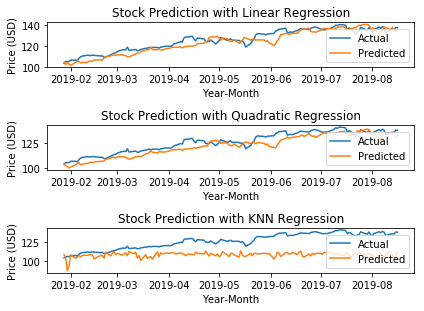

In [24]:
test_period = df.index[:-n][-test_days:]
for i in range(len(models)):
    plt.tight_layout()
    plt.subplot(3, 1, i+1)
    y_preds = model_objects[i].predict(X_test)
    plt.plot(test_period, y_test, label='Actual')
    plt.plot(test_period, y_preds, label='Predicted')
    plt.title('Stock Prediction with {} Regression'.format(models[i]))
    plt.ylabel('Price (USD)')
    plt.xlabel('Year-Month')
    plt.legend()

### Conclusion
Given the above data and using input features ['Adj Close', 'Volume', 'HL_PCT', 'PCT_change'], Linear Regression Model may give at least a good idea of the trend of the stock price 10 days later.